<a href="https://colab.research.google.com/github/rohithmn01/prom_forecast/blob/main/Auto_Arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import requests
import copy 
import pandas as pd
URL = "http://34.67.240.237:30000/api/v1/query?query=node_memory_MemFree_bytes{instance=\"10.56.0.2:9100\",job=\"node-exporter\"}[1d]" 
r = requests.get(url = URL) 

data = r.json()

data_dict={}
metric_list = []

for i in data['data']['result']:
    counter=0
    for j in i['values']:
        data_dict = copy.deepcopy(i['metric'])
        data_dict['time'] = j[0]
        data_dict['value'] = j[1]
        metric_list.append(data_dict)        
  
df_metric = pd.DataFrame(metric_list)

df1 = df_metric[['time', 'value']]
df1['time'] = pd.to_datetime(df1['time'],unit='s')
df1 = df1.set_index('time')
df1["value"] = df1.values.astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
df1

,value
time,
2021-08-29 11:04:27.460000038,2.615697e+09
2021-08-29 11:04:32.460000038,2.614858e+09
2021-08-29 11:04:37.460000038,2.614641e+09
2021-08-29 11:04:42.460000038,2.614600e+09
2021-08-29 11:04:47.460000038,2.616771e+09
...,...
2021-08-30 11:04:02.460000038,2.587505e+09
2021-08-30 11:04:07.460000038,2.588054e+09
2021-08-30 11:04:12.460000038,2.587496e+09


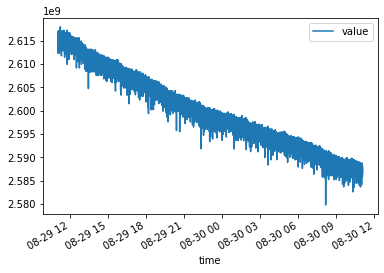

In [8]:
df1.plot()

In [9]:
df1.describe()

,value
count,1.728000e+04
mean,2.600127e+09
std,8.222588e+06
min,2.579837e+09
25%,2.593386e+09
50%,2.599072e+09
75%,2.606979e+09
max,2.617995e+09


In [10]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adfuller_test(df1['value'])

ADF Test Statistic : -1.1519435069562816
p-value : 0.6939195419369215
#Lags Used : 43
Number of Observations Used : 17236
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pylab as plt
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

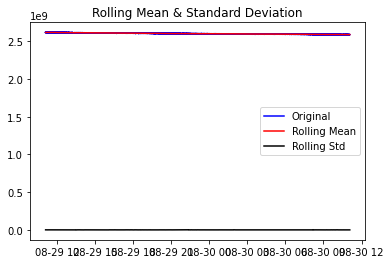

Results of Dickey-Fuller Test:
Test Statistic                    -1.151944
p-value                            0.693920
#Lags Used                        43.000000
Number of Observations Used    17236.000000
Critical Value (1%)               -3.430729
Critical Value (5%)               -2.861708
Critical Value (10%)              -2.566859
dtype: float64


In [13]:
test_stationarity(df1['value'])

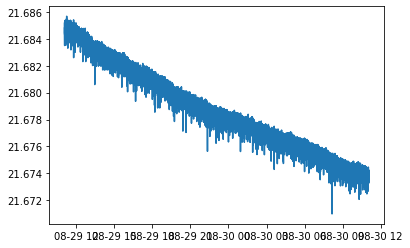

In [14]:
#make the time series stationary
#MAKING TS STATIONARY
import numpy as np
ts_log = np.log(df1['value'])
plt.plot(ts_log)

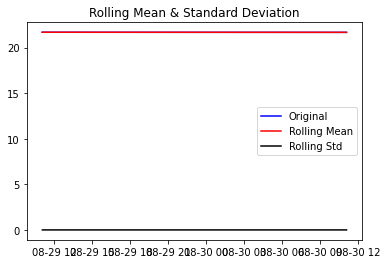

Results of Dickey-Fuller Test:
Test Statistic                    -1.138833
p-value                            0.699340
#Lags Used                        43.000000
Number of Observations Used    17236.000000
Critical Value (1%)               -3.430729
Critical Value (5%)               -2.861708
Critical Value (10%)              -2.566859
dtype: float64


In [15]:
test_stationarity(ts_log)


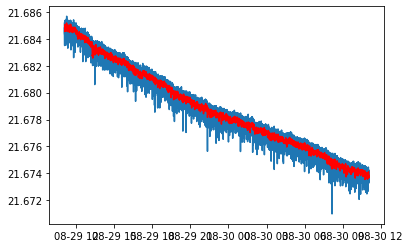

In [16]:
#Smoothing
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [17]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(5)

time
2021-08-29 11:04:27.460000038   NaN
2021-08-29 11:04:32.460000038   NaN
2021-08-29 11:04:37.460000038   NaN
2021-08-29 11:04:42.460000038   NaN
2021-08-29 11:04:47.460000038   NaN
Name: value, dtype: float64

In [18]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head(5)

time
2021-08-29 11:05:22.460000038    0.000715
2021-08-29 11:05:27.460000038   -0.000037
2021-08-29 11:05:32.460000038    0.000221
2021-08-29 11:05:37.460000038   -0.000366
2021-08-29 11:05:42.460000038    0.000447
Name: value, dtype: float64

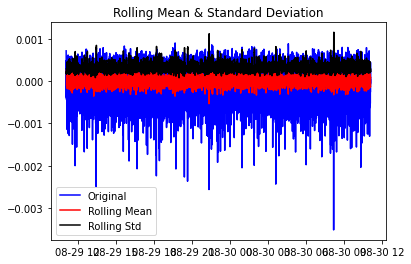

Results of Dickey-Fuller Test:
Test Statistic                   -29.140452
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations Used    17224.000000
Critical Value (1%)               -3.430730
Critical Value (5%)               -2.861708
Critical Value (10%)              -2.566859
dtype: float64


In [19]:
#TEST STATIONARITY AGAIN
test_stationarity(ts_log_moving_avg_diff)

In [21]:
#ts_log.values
ts_values=ts_log.values

In [22]:
X = ts_values
size = int(len(X) * 0.667)
train, test = X[0:size], X[size:len(X)]

In [1]:
### AUTO ARIMA
!pip install pmdarima


In [23]:
from pmdarima.arima import auto_arima


In [24]:
arima_model = auto_arima(train, start_p=1, start_q=1, d=1, max_p=4, max_q=4, start_P=1, 
                         D=None, start_Q=1, max_P=4, max_D=1, max_Q=4, max_order=5, m=1, 
                         seasonal=True, stationary=False, information_criterion='aic', 
                         alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, 
                         n_jobs=1, start_params=None, trend=None, method='lbfgs', 
                         maxiter=50, offset_test_args=None, seasonal_test_args=None, 
                         suppress_warnings=True, error_action='trace', trace=False, 
                         random=False, random_state=None, n_fits=10, 
                         return_valid_fits=False, out_of_sample_size=0, 
                         scoring='mse', scoring_args=None, with_intercept='auto', 
                         sarimax_kwargs=None)

In [25]:
arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11525
Model:               SARIMAX(4, 1, 3)   Log Likelihood               74847.476
Date:                Mon, 30 Aug 2021   AIC                        -149676.952
Time:                        11:10:51   BIC                        -149610.782
Sample:                             0   HQIC                       -149654.711
                              - 11525                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.027e-06   1.14e-06     -2.650      0.008   -5.27e-06   -7.88e-07
ar.L1         -0.6062      0.005   -113.622      0.000      -0.617      -0.596
ar.L2         -0.6749      0.009    -78.510      0.000      -0.692      -0.658
ar.L3          0.1393      0.016      8.604      0.000       0.108       0.171
ar.L4          0.0306      0.011      2.746      0.006       0.009       0.052
ma.L1         -0.1625      0.005    -32.614      0.000      -0.172      -0.153
ma.L2          0.1533      0.005     29.175      0.000       0.143       0.164
ma.L3         -0.7028      0.012    -56.752      0.000      -0.727      -0.679
sigma2      1.383e-07   1.38e-09    100.135      0.000    1.36e-07    1.41e-07
===================================================================================
Ljung-Box (L1) (Q):                  19.46   Jarque-Bera (JB):              5809.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -0.99
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+17. Standard errors may be unstable.
"""

In [26]:
prediction_arima_model = pd.DataFrame(arima_model.predict(n_periods=len(test)))
prediction_arima_model.columns = ['predicted_memory_free_bytes']

In [27]:
np.exp(prediction_arima_model)

,predicted_memory_free_bytes
0,2.594983e+09
1,2.595054e+09
2,2.594940e+09
3,2.594943e+09
4,2.595028e+09
...,...
5750,2.573678e+09
5751,2.573675e+09
5752,2.573671e+09
5753,2.573667e+09


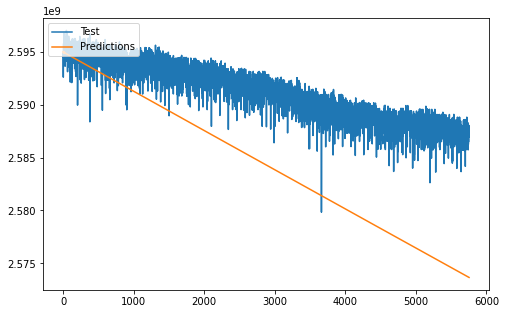

In [28]:
plt.figure(figsize=(8,5))
#plt.plot(train, label='Training')
plt.plot(np.exp(test), label='Test')
plt.plot(np.exp(prediction_arima_model), label='Predictions')
plt.legend(loc = 'upper left')
plt.show()